In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
origdf = pd.read_csv("data/training_data.csv")

In [6]:
subm = pd.read_csv("data/data_submission_example.csv")

In [7]:
# Egyszerű-egyszerű megoldás

In [8]:
df = origdf.copy()

In [9]:
# DataPreparation

<Axes: >

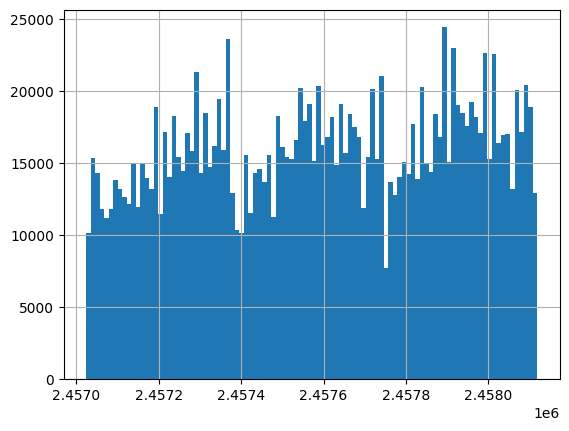

In [10]:
df['CONTRACT_DATE_OF_LOAN_AGREEMENT'].hist(bins=100)

<Axes: >

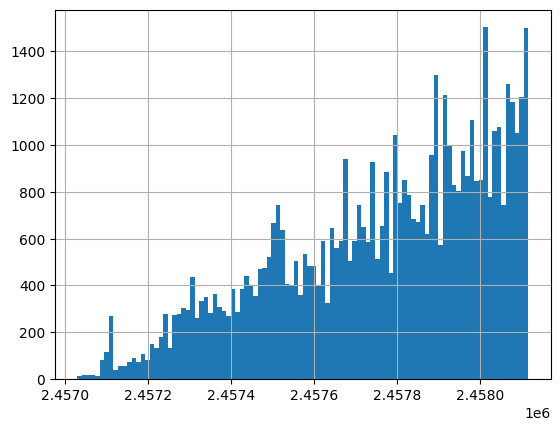

In [11]:
df['TARGET_EVENT_DAY'].hist(bins=100)

In [12]:
specidf = df[df['TARGET_EVENT']!='-'].copy()

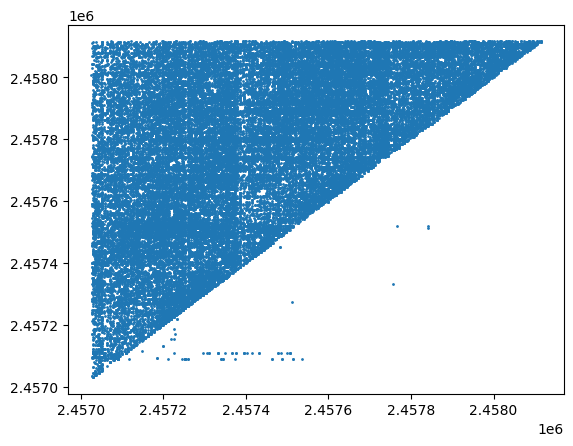

In [13]:
plt.scatter(specidf['CONTRACT_DATE_OF_LOAN_AGREEMENT'],specidf['TARGET_EVENT_DAY'],s=1)

In [14]:
bdf=specidf[specidf['CONTRACT_DATE_OF_LOAN_AGREEMENT']<2457029]
cdf=bdf.sort_values('TARGET_EVENT_DAY').head(1)
cdf

,CONTRACT_ID,BORROWER_ID,CONTRACT_BANK_ID,CONTRACT_CREDIT_INTERMEDIARY,CONTRACT_CREDIT_LOSS,CONTRACT_CURRENCY,CONTRACT_DATE_OF_LOAN_AGREEMENT,CONTRACT_DEPT_SERVICE_TO_INCOME,CONTRACT_FREQUENCY_TYPE,CONTRACT_INCOME,...,CONTRACT_RISK_WEIGHTED_ASSETS,CONTRACT_TYPE_OF_INTEREST_REPAYMENT,BORROWER_BIRTH_YEAR,BORROWER_CITIZENSHIP,BORROWER_COUNTRY,BORROWER_COUNTY,BORROWER_TYPE_OF_CUSTOMER,BORROWER_TYPE_OF_SETTLEMENT,TARGET_EVENT,TARGET_EVENT_DAY
1424714,rrn-5qiM,+0NOwYK0,1d42bbf5,2.0,252761.0,31,2457028,NaN,479a2e13,NaN,...,74.83,100002.0,1232.0,98.0,98.0,97.0,B,2.0,E,2457035.0


In [15]:
specidf['MeddigBirta']=specidf['TARGET_EVENT_DAY']-specidf['CONTRACT_DATE_OF_LOAN_AGREEMENT']

<Axes: >

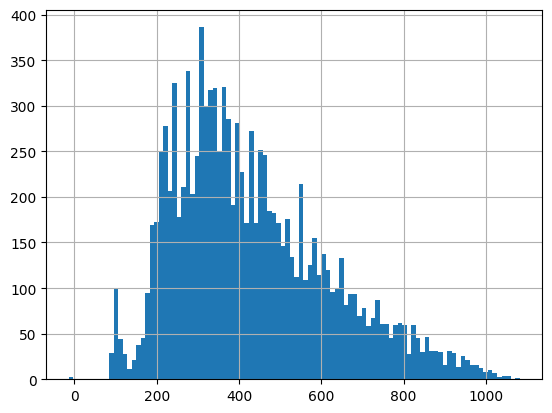

In [16]:
ddf=specidf[specidf['TARGET_EVENT']=='K']
ddf['MeddigBirta'].hist(bins=100)

In [17]:
eltolas = df['CONTRACT_DATE_OF_LOAN_AGREEMENT'].min()


In [18]:
df['CONTRACT_DATE_OF_LOAN_AGREEMENT'].max()-df['CONTRACT_DATE_OF_LOAN_AGREEMENT'].min()

1094

In [19]:
df['CONTRACT_DATE_OF_LOAN_AGREEMENT']=df['CONTRACT_DATE_OF_LOAN_AGREEMENT']-eltolas

In [20]:
df['TARGET_EVENT_DAY']=df['TARGET_EVENT_DAY']-eltolas

<Axes: >

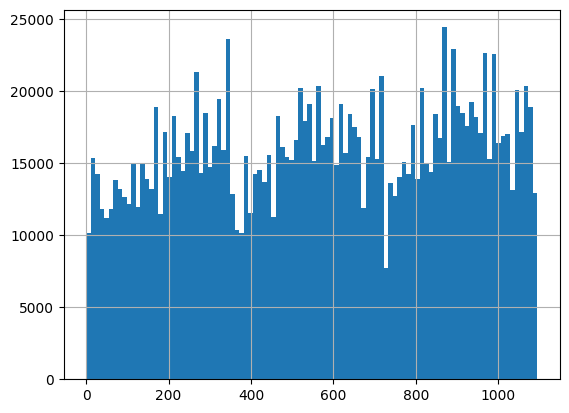

In [21]:
df['CONTRACT_DATE_OF_LOAN_AGREEMENT'].hist(bins=100)

<Axes: >

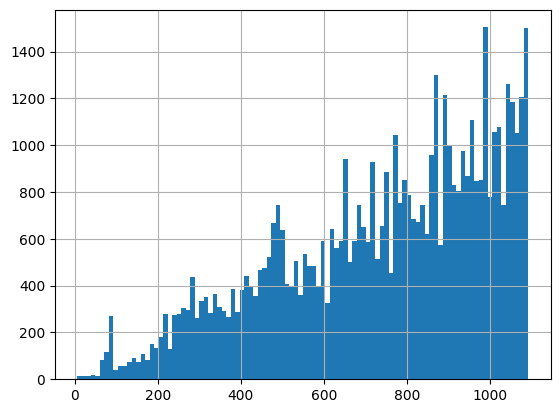

In [22]:
df['TARGET_EVENT_DAY'].hist(bins=100)

# ModeA terv:
- Első 365 nap adatából készítek tanító adathalmazt célváltozóval - R1 adathalmaz
- Az utolsó 365 nap adatából ugyanezt, de ugye ott nem lesz értelmes célválozó - R2 adathalmaz
- Modellt építek R1-en, optimalizálom, javítgatom, majd alkalmazom a beküldőn R2 adathalmazon

In [23]:
def datagen_modeA(df,startnap, endnap):
    pass

R1 = datagen_modeA(df,0,365)
R2 = datagen_modeA(df,365*2,365*3)

In [24]:
def datagen_modeA(origdf,startnap, endnap):
    df2 = origdf[ origdf['CONTRACT_DATE_OF_LOAN_AGREEMENT']>=startnap].copy()
    df = df2[ df2['CONTRACT_DATE_OF_LOAN_AGREEMENT']<endnap].copy()
    
    cust_df = pd.DataFrame({'BORROWER_ID':df['BORROWER_ID'].unique()})
    # TARGET VALTOZO KESZITES
    feltetel=(df['TARGET_EVENT_DAY']>endnap) & (df['TARGET_EVENT_DAY']<endnap+2*365) & (df['TARGET_EVENT']=='K') 
    df['target']=0
    df.loc[feltetel,'target']=1
    
    stat = df.groupby("BORROWER_ID",as_index=False).agg({'target':'max'})
    cust_df=cust_df.merge(stat,on='BORROWER_ID',how='left')
    cust_df['target']=cust_df['target'].fillna(0)  
    return cust_df

R1 = datagen_modeA(df,0,365)
R2 = datagen_modeA(df,365*2,365*3)

In [25]:
def datagen_modeA(origdf,startnap, endnap):
    df2 = origdf[ origdf['CONTRACT_DATE_OF_LOAN_AGREEMENT']>=startnap].copy()
    df = df2[ df2['CONTRACT_DATE_OF_LOAN_AGREEMENT']<endnap].copy()
    
    cust_df = pd.DataFrame({'BORROWER_ID':df['BORROWER_ID'].unique()})
    # TARGET VALTOZO KESZITES
    feltetel=(df['TARGET_EVENT_DAY']>endnap) & (df['TARGET_EVENT_DAY']<endnap+2*365) & (df['TARGET_EVENT']=='K') 
    df['target']=0
    df.loc[feltetel,'target']=1
    
    stat = df.groupby("BORROWER_ID",as_index=False).agg({'target':'max'})
    cust_df=cust_df.merge(stat,on='BORROWER_ID',how='left')
    cust_df['target']=cust_df['target'].fillna(0)  
    
    # BEMENO_VALTOZOKAT
    stat = df.groupby("BORROWER_ID",as_index=False).agg(
        {'CONTRACT_ID':'count','CONTRACT_LOAN_AMOUNT':'sum'})
    stat.columns=['BORROWER_ID','in_contract_num','in_loan_amount_sum']
    cust_df=cust_df.merge(stat,on='BORROWER_ID',how='left')
    return cust_df

R1 = datagen_modeA(df,0,365)
R2 = datagen_modeA(df,0,365*3)

In [45]:
R2 = datagen_modeA(df,0,365*3)

In [27]:
# R1 felén tanulunk, másik felén tesztelünk, milyen loglosst kapunk?

In [28]:
from sklearn.model_selection import cross_val_predict

In [29]:
#cross_val_predict(cv)

In [30]:
R1=R1.reset_index(drop=True)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

In [32]:
R1.columns

Index(['BORROWER_ID', 'target', 'in_contract_num', 'in_loan_amount_sum'], dtype='object')

In [33]:
bemeno_valtozok=['in_contract_num', 'in_loan_amount_sum']
cv=5
R1['fold']=R1.index % cv
loglosslist=[]
for i in range(cv):
    train_df=R1[R1['fold']!=i]
    test_df =R1[R1['fold']==i].copy()
    gbm = GradientBoostingClassifier(n_estimators=100,
                                     max_depth=3,
                                     random_state=42)
    gbm.fit(train_df[bemeno_valtozok],train_df['target'])
    test_df['p']=gbm.predict_proba(test_df[bemeno_valtozok])[:,1]
    logloss = log_loss(test_df['target'],test_df['p'])
    print(i,logloss)
    loglosslist.append(logloss)
print("ATLAGOS LOGLOSS:",np.mean(loglosslist))
    

0 0.05773247362685764
1 0.06047312007848757
2 0.05962288196493838
3 0.06300295596650712
4 0.060187070094049985
ATLAGOS LOGLOSS: 0.06020370034616814


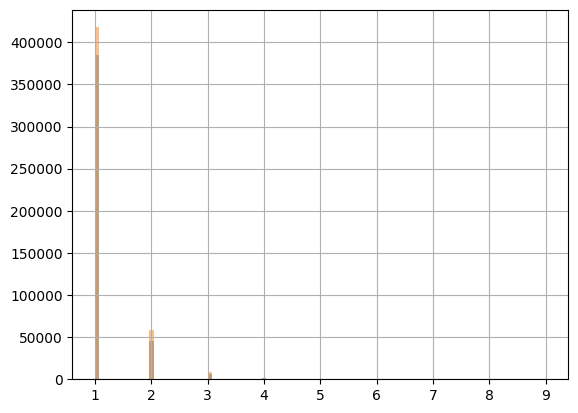

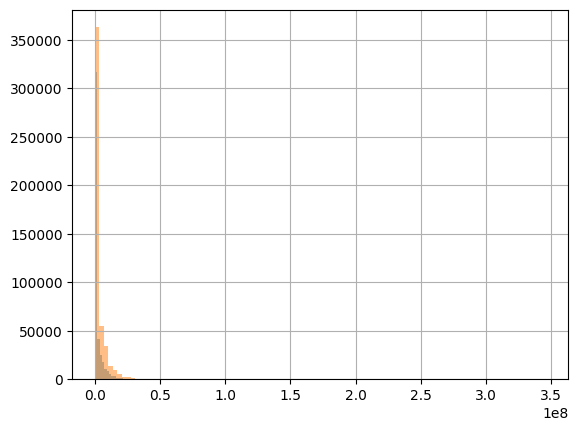

In [34]:
r1=R1[R1['in_contract_num']<10]
r2=R2[R2['in_contract_num']<10]

for v in bemeno_valtozok:
    r1[v].hist(bins=100,alpha=0.5)
    r2[v].hist(bins=100,alpha=0.5)
    plt.show()

In [35]:
gbm.fit(R1[bemeno_valtozok],R1['target'])

GradientBoostingClassifier(random_state=42)

In [46]:
R2['p']=gbm.predict_proba(R2[bemeno_valtozok])[:,1]

In [47]:
R2['p'].mean()

0.013686548226481073

In [48]:
R2=R2.drop('target', axis=1)
R2=R2.drop('in_contract_num', axis=1)
R2=R2.drop('in_loan_amount_sum', axis=1)

In [49]:
R2.columns=['BORROWER_ID','PRED']

In [51]:
merged_df = R2[R2['BORROWER_ID'].isin(subm['BORROWER_ID'])]

In [52]:
merged_df.shape

(1117674, 2)

In [ ]:
#alap=0.07572668535990017

#Uj  =0.07660933875373632

#Megjobb = 0.07583603010855205

In [ ]:
subm2 = subm.merge(R2[['BORROWER_ID','p3']],on='BORROWER_ID',how='left')

In [ ]:
subm2.loc[ ~subm2['p3'].isna() ,'PRED']=subm2.loc[ ~subm2['p3'].isna() ,'p3']

In [ ]:
subm2['PRED'].mean()

In [ ]:
subm['PRED'].mean()

In [ ]:
subm2=subm2.drop('p3', axis=1)

In [54]:
merged_df.to_csv("orai_proba_2.csv",index=None)

In [55]:
merged_df

,BORROWER_ID,PRED
0,d8SqtuEV,0.019991
1,lrdxML0g,0.001034
2,gII7nnq4,0.018299
3,MMkJ8z/e,0.009212
4,M417onFP,0.012362
...,...,...
1149846,POeQToeq,0.014067
1149847,C0amt32x,0.018128
1149848,WW5vgE+y,0.001802
1149849,26ZlUKOa,0.001582
